# Analysis of VoC data

Look at data provided to SPI-M on the B.1.351 VoC. File not included in the repo, so change path if running independently. Data is that provided on 14 April and samples run up to the end of March.


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import scipy.special as sp
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import scipy.optimize as op

In [2]:
df = pd.read_excel(
    '/Volumes/COVID19_Epi_modelling/DstlDailyData/2021-04-14/VOC202012_02_linelist_20210413.xlsx',
    sheet_name=1,
)
df.dropna(subset=['earliest_specimen_date'],inplace=True)

In [3]:
def todays(x):
    return np.array((pd.to_datetime(x['earliest_specimen_date'], format='%d/%m/%Y') - pd.Timestamp("2020-10-01")) // pd.Timedelta('1D'))

In [4]:
dfg = df.groupby('exposure_type').apply(todays)

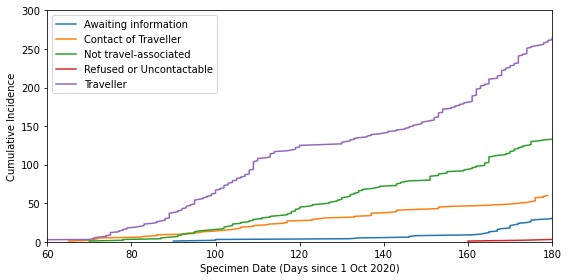

In [5]:
plt.figure(figsize=(8,4))
for i in range(0,len(dfg.index)):
    x = dfg[i]
    plt.plot(np.sort(x),np.arange(1,len(x)+1),label=dfg.index[i])
plt.legend()
plt.xlabel('Specimen Date (Days since 1 Oct 2020)')
plt.ylabel('Cumulative Incidence')
plt.ylim([0,300])
plt.xlim([60,180])
plt.tight_layout()
#plt.savefig('./voc_c.pdf')

In [6]:
# Use this to estimate a 'realistic' FOI from a Gamma process
# Also remove the first point to avoid problems

In [7]:
x = df.apply(todays,axis=1)

In [8]:
dts = np.array([30,45,60,90])
cols = ['r','g','b','m']

In [9]:
todays(pd.DataFrame(['29/03/2021'],columns=['earliest_specimen_date']))

array([179])

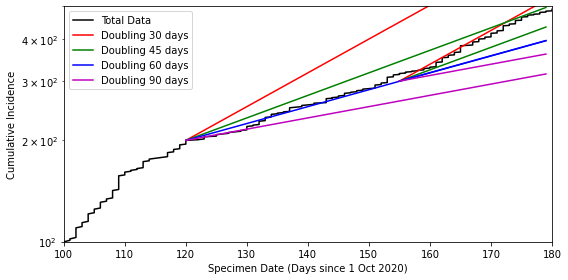

In [10]:
plt.figure(figsize=(8,4))
plt.plot(np.sort(x),np.arange(1,len(x)+1),label='Total Data',c='k')
uu = np.arange(120,180)
vv = np.arange(155,180)
for j, dt in enumerate(dts):
    plt.plot(uu,200*np.exp((np.log(2)/dt)*(uu-120)),label= 'Doubling ' + str(dt) + ' days',c=cols[j])
    plt.plot(vv,300*np.exp((np.log(2)/dt)*(vv-155)),c=cols[j])
plt.ylim([100,500])
plt.xlim([100,180])
plt.yscale('log')
plt.xlabel('Specimen Date (Days since 1 Oct 2020)')
plt.ylabel('Cumulative Incidence')
plt.legend()
plt.tight_layout()
#plt.savefig('./voc_tot.pdf')

In [11]:
traw = np.sort(x[x>=70])
tmin = np.min(traw)
traw -= tmin

In [12]:
tt, yy = np.unique(traw, return_counts=True)
cc = np.cumsum(yy)
n = len(tt)
tt = tt.astype(np.double)
cc = cc.astype(np.double)

In [13]:
def nllfun(x,tt,cc,nn):
    t = np.zeros_like(cc)
    y = np.zeros_like(cc)
    al = np.zeros_like(cc)
    bt = np.zeros_like(cc)
    al[0] = x[0]
    bt[0] = x[1]
    ga = x[2]
    nll=0
    for i in range(1,nn):
        y[i] = cc[i] - cc[i-1]
        t[i] = tt[i] - tt[i-1]
        al[i] = np.exp(-ga*t[i])*al[i-1]
        bt[i] = np.exp(-ga*t[i])*bt[i-1]
        nll -= y[i]*np.log(t[i]/(t[i]+bt[i])) + al[i]*np.log((bt[i]/(t[i]+bt[i])))
        nll -= sp.gammaln(al[i]+y[i]) - sp.gammaln(1+y[i]) - sp.gammaln(al[i])
        al[i] += y[i]
        bt[i] += t[i]
    return nll

In [14]:
#Optimizer to fit the initial conditions
nll = lambda xx: nllfun(np.abs(xx),tt,cc,n)
fout = op.minimize(nll,np.array([1.,1.,0.]),method='Nelder-Mead')
astar = np.abs(fout.x[0])
bstar = np.abs(fout.x[1])
cstar = np.abs(fout.x[2])
fout

 final_simplex: (array([[-2.65420493e+04,  1.19781211e+04,  5.01188974e-01],
       [-2.65420493e+04,  1.19781210e+04,  5.01188974e-01],
       [-2.65420493e+04,  1.19781210e+04,  5.01188974e-01],
       [-2.65420492e+04,  1.19781210e+04,  5.01188974e-01]]), array([267.44561675, 267.44561675, 267.44561675, 267.44561675]))
           fun: 267.4456167471974
       message: 'Optimization terminated successfully.'
          nfev: 468
           nit: 249
        status: 0
       success: True
             x: array([-2.65420493e+04,  1.19781211e+04,  5.01188974e-01])

In [15]:
def run_gamproc(tt,cc,astar,bstar):
    t = np.zeros_like(cc)
    y = np.zeros_like(cc)
    al = np.zeros_like(cc)
    bt = np.zeros_like(cc)
    lam = np.zeros_like(cc)
    lal = np.zeros_like(cc)
    lau = np.zeros_like(cc)
    n = len(cc)
    al[0] = astar
    bt[0] = bstar
    ga = cstar
    lam[0] = st.gamma.mean(al[0],0,1/bt[0])
    lal[0] = st.gamma.ppf(0.025,al[0],0,1/bt[0])
    lau[0] = st.gamma.ppf(0.975,al[0],0,1/bt[0])
    for i in range(1,n):
        y[i] = cc[i] - cc[i-1]
        t[i] = tt[i] - tt[i-1]
        al[i] = np.exp(-ga*t[i])*al[i-1]
        bt[i] = np.exp(-ga*t[i])*bt[i-1]
        al[i] += y[i]
        bt[i] += t[i]
        lam[i] = st.gamma.mean(al[i],0,1/bt[i])
        lal[i] = st.gamma.ppf(0.025,al[i],0,1/bt[i])
        lau[i] = st.gamma.ppf(0.975,al[i],0,1/bt[i])
    am = al
    bm = bt
    dt = np.gradient(tt)
    dth = (np.gradient(bm)/(-1.0*bm**2))/dt
    da = (np.gradient(am))/dt
    rm = (dth*bm) + (sp.polygamma(1,am)*da)
    rv = (sp.polygamma(2,am)*da)
    rs = np.sqrt(-rv)
    return lam, lal, lau, rm, rs

In [16]:
lam, lal, lau, rm, rs = run_gamproc(tt,cc,astar,bstar)

<ipython-input-15-24dabb72a885>:33: RuntimeWarning: invalid value encountered in sqrt
  rs = np.sqrt(-rv)


In [17]:
dts = np.array([21,30,45])

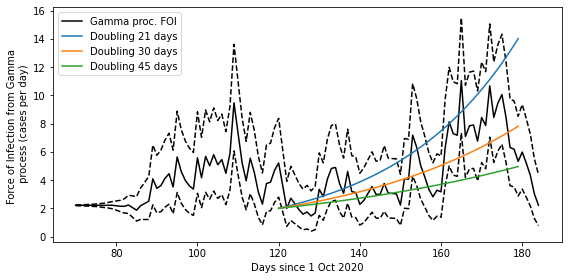

In [18]:
plt.figure(figsize=(8, 4))
plt.plot(tt+tmin,lam,c=[0, 0, 0],label='Gamma proc. FOI')
plt.plot(tt+tmin,lal,c=[0, 0, 0],linestyle='dashed')
plt.plot(tt+tmin,lau,c=[0, 0, 0],linestyle='dashed')
for dt in dts:
    plt.plot(uu,2*np.exp((np.log(2)/dt)*(uu-120)),label= 'Doubling ' + str(dt) + ' days')
plt.xlabel('Days since 1 Oct 2020')
plt.ylabel('Force of Infection from Gamma \n process (cases per day)')
plt.legend()
plt.tight_layout()
#plt.savefig('./voc_la.pdf')

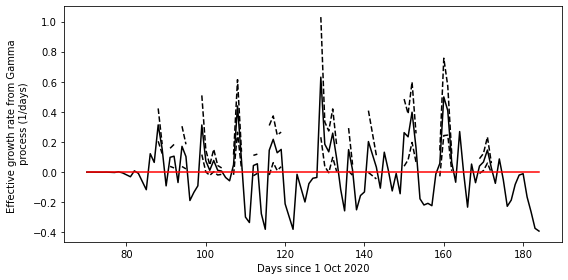

In [19]:
plt.figure(figsize=(8, 4))
plt.plot(tt+tmin,rm,c=[0,0,0])
plt.plot(tt+tmin,rm-rs,c=[0,0,0],linestyle='dashed')
plt.plot(tt+tmin,rm+rs,c=[0,0,0],linestyle='dashed')
plt.plot(tt+tmin,0*tt,c=[1,0,0])
plt.xlabel('Days since 1 Oct 2020')
plt.ylabel('Effective growth rate from Gamma \n process (1/days)')
plt.tight_layout()
#plt.savefig('./voc_r.pdf')

In [20]:
# Look at the distribution in households and compare to a conditional Poisson to look for overdispersal
hh = df.groupby('hh_id').apply(len)
y, be = np.histogram(hh,bins=np.arange(1,np.max(hh)+3))
n = np.sum(hh)
yy = y/n
xx = be[0:-1]

In [21]:
xbar = np.mean(hh)
xbar

1.2106537530266344

In [22]:
def cpfun(la):
    return ((la/(1. - np.exp(-la))) - xbar)

In [23]:
lahat = op.brentq(cpfun,1e-6,xbar)
lahat

0.3953277611745434

In [24]:
lavar = (lahat/n)*((1. - np.exp(-lahat))**2)/(1. - (lahat + 1)*np.exp(-lahat))
sig = np.sqrt(lavar)

In [25]:
zm = st.poisson.pmf(xx,lahat)/(1-st.poisson.pmf(0,lahat))
zl = st.poisson.pmf(xx,lahat-2.*sig)/(1-st.poisson.pmf(0,lahat-2.*sig))
zu = st.poisson.pmf(xx,lahat+2.*sig)/(1-st.poisson.pmf(0,lahat+2.*sig))

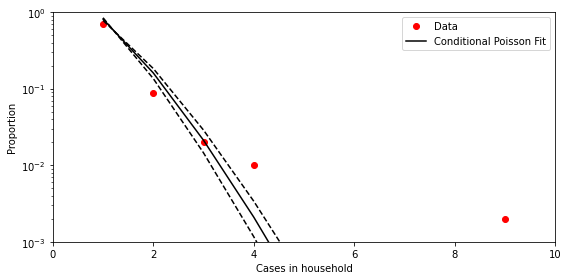

In [26]:
plt.figure(figsize=(8,4))
plt.plot(xx,yy,ls='',marker='o',c='r',label='Data')
plt.plot(xx,zm,ls='-',c='k',label='Conditional Poisson Fit')
plt.plot(xx,zl,ls='--',c='k')
plt.plot(xx,zu,ls='--',c='k')
plt.yscale('log')
plt.xlim([0,10])
plt.ylim([1e-3,1])
plt.xlabel('Cases in household')
plt.ylabel('Proportion')
plt.legend()
plt.tight_layout()
#plt.savefig('./voc_hh.pdf')

In [27]:
dfr = df.groupby('PHEC_name').apply(todays)

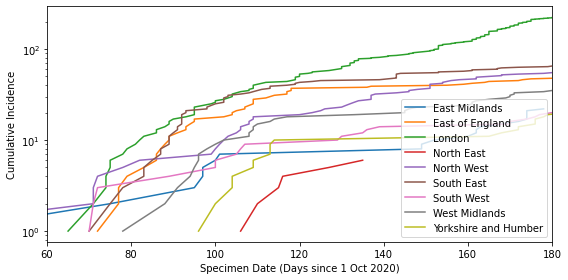

In [28]:
plt.figure(figsize=(8,4))
for i in range(0,len(dfr.index)):
    x = dfr[i]
    plt.plot(np.sort(x),np.arange(1,len(x)+1),label=dfr.index[i])
plt.legend()
plt.xlabel('Specimen Date (Days since 1 Oct 2020)')
plt.ylabel('Cumulative Incidence')
plt.xlim([60,180])
plt.yscale('log')
plt.tight_layout()
#plt.savefig('./voc_region_log.pdf')

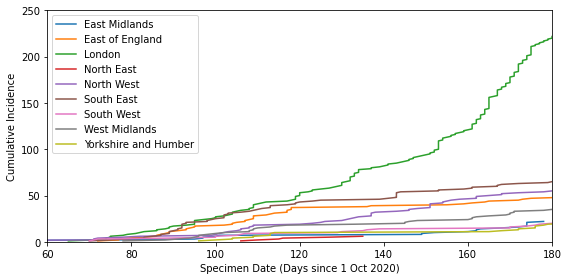

In [29]:
plt.figure(figsize=(8,4))
for i in range(0,len(dfr.index)):
    x = dfr[i]
    plt.plot(np.sort(x),np.arange(1,len(x)+1),label=dfr.index[i])
plt.legend()
plt.xlabel('Specimen Date (Days since 1 Oct 2020)')
plt.ylabel('Cumulative Incidence')
plt.ylim([0,250])
plt.xlim([60,180])
plt.tight_layout()
#plt.savefig('./voc_region_lin.pdf')